In [92]:
import pandas as pd
import sklearn as skt
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from hmmlearn.hmm import GaussianHMM
import seaborn as sns


In [93]:
#1 Import Data
df = pd.read_csv('./LAX Temperature.csv')

In [94]:
#2 Keep only the date and temperature
print(df.head())
df = df.drop(columns=['Time','date_time'])
df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%Y')


         Date     Time         date_time  air_temp_high_24_hour
0  11/24/2023  07:53AM  11/24/23-07:53AM                  69.98
1  11/23/2023  07:53AM  11/23/23-07:53AM                  82.94
2  11/22/2023  07:53AM  11/22/23-07:53AM                  82.04
3  11/21/2023  07:53AM  11/21/23-07:53AM                  73.04
4  11/20/2023  07:53AM  11/20/23-07:53AM                  71.96


In [95]:
#3 Set the date as the index
df.set_index('Date', inplace=True)
print(df.head())


            air_temp_high_24_hour
Date                             
2023-11-24                  69.98
2023-11-23                  82.94
2023-11-22                  82.04
2023-11-21                  73.04
2023-11-20                  71.96


In [96]:
#4.	Split the data into train and test, Train should be 2005 – 2022. Test should be 2023 onward. Format of date index 11/24/2023
x_train = df.sort_index().loc['2005-01-01':'2022-12-31']
x_test = df.sort_index().loc['2023-01-01':]
df_train = x_train
df_test = x_test



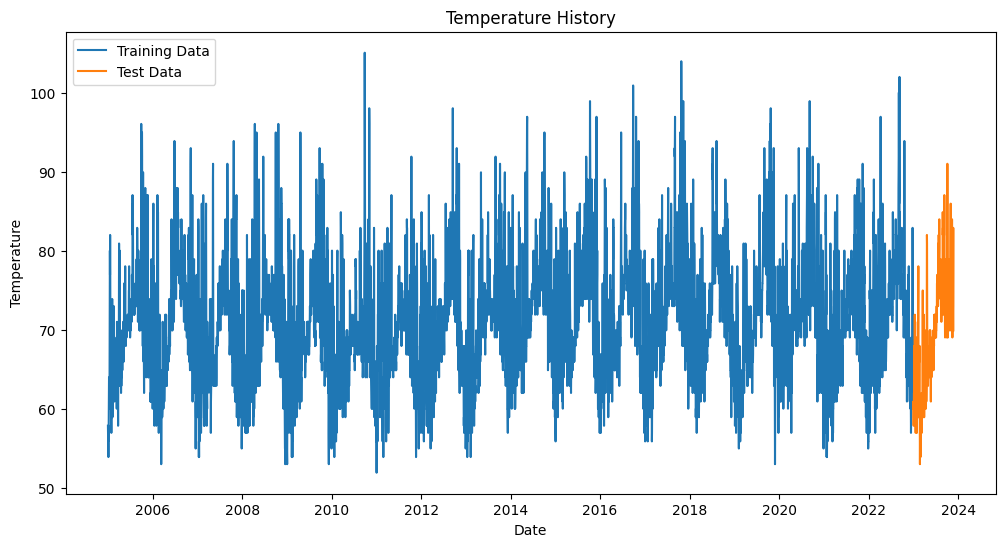

In [97]:
#5 visualize the time series data
plt.figure(figsize=(12,6))
plt.title('Temperature History')
plt.plot(x_train['air_temp_high_24_hour'], label='Training Data')
plt.plot(x_test['air_temp_high_24_hour'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [98]:
#6 Scale the data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#7 make a sequence to predict the next value using the previous 24 days
window_size = 24
max_length = x_train.shape[0]
y = x_train[window_size:max_length+1].squeeze()
X = []
    #time window
for i in range (y.shape[0]):
    appendlist = x_train[i:i+window_size]
    X.append(appendlist)
X = np.array(X).squeeze()
print(X)
print(y)

[[0.11186441 0.09491525 0.07457627 ... 0.18983051 0.2440678  0.28135593]
 [0.09491525 0.07457627 0.09491525 ... 0.2440678  0.28135593 0.26440678]
 [0.07457627 0.09491525 0.03728814 ... 0.28135593 0.26440678 0.18983051]
 ...
 [0.22711864 0.16949153 0.16949153 ... 0.58305085 0.49152542 0.22711864]
 [0.16949153 0.16949153 0.15254237 ... 0.49152542 0.22711864 0.20677966]
 [0.16949153 0.15254237 0.15254237 ... 0.22711864 0.20677966 0.15254237]]
[0.26440678 0.18983051 0.16949153 ... 0.20677966 0.15254237 0.15254237]


In [99]:
#8 build the DNN
nn_model = tf.keras.Sequential()
nn_model.add(tf.keras.Input(shape=(window_size,)))
nn_model.add(tf.keras.layers.Dense(200, activation='relu'))
nn_model.add(tf.keras.layers.Dense(1000, activation='relu'))
nn_model.add(tf.keras.layers.Dense(5000, activation='relu'))
nn_model.add(tf.keras.layers.Dense(2500, activation='relu'))
nn_model.add(tf.keras.layers.Dense(500, activation='relu'))
nn_model.add(tf.keras.layers.Dense(1, activation='linear'))
#9 compile the model
nn_model.compile(
        optimizer='adam',
        loss="mse",
        metrics=['accuracy']
    )

In [106]:
#9 cont train the model
nn_model.fit(X, y, batch_size=40, epochs=30)
    #predict the data and inverse scale temp (Step 11)
prediction = nn_model.predict(X)
scale_pred = scaler.inverse_transform(prediction)
    #evaluate the model (Step 12)
loss, acc = nn_model.evaluate(X, y)
mse = mean_squared_error(y, scale_pred)
print("MSE: ", mse)
print("loss: ", loss)
print("Acc: ", acc)

Epoch 1/30
163/163 [==============================] - 4s 22ms/step - loss: 0.0076 - accuracy: 3.0689e-04
Epoch 2/30
163/163 [==============================] - 4s 25ms/step - loss: 0.0077 - accuracy: 3.0689e-04
Epoch 3/30
163/163 [==============================] - 4s 22ms/step - loss: 0.0071 - accuracy: 3.0689e-04
Epoch 4/30
163/163 [==============================] - 4s 23ms/step - loss: 0.0073 - accuracy: 3.0689e-04
Epoch 5/30
163/163 [==============================] - 4s 22ms/step - loss: 0.0069 - accuracy: 3.0689e-04
Epoch 6/30
163/163 [==============================] - 4s 23ms/step - loss: 0.0068 - accuracy: 3.0689e-04
Epoch 7/30
163/163 [==============================] - 4s 22ms/step - loss: 0.0067 - accuracy: 3.0689e-04
Epoch 8/30
163/163 [==============================] - 4s 22ms/step - loss: 0.0068 - accuracy: 3.0689e-04
Epoch 9/30
163/163 [==============================] - 4s 22ms/step - loss: 0.0066 - accuracy: 3.0689e-04
Epoch 10/30
163/163 [==============================] - 

300
10/10 [==============================] - 0s 6ms/step
(300, 1)


/var/folders/2t/2y0f_lxd6w3806pjj2pppbx80000gn/T/ipykernel_45411/180818770.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


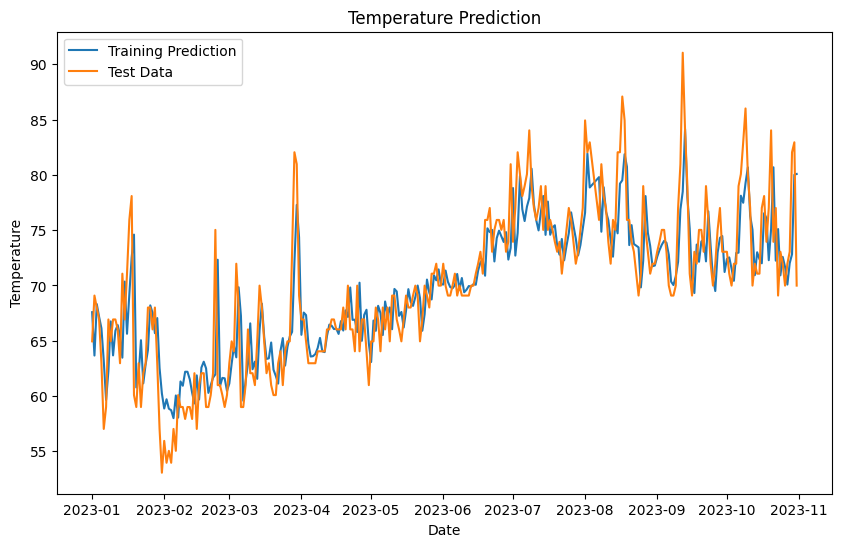

In [101]:
#need to get the test data in the same format as the training data
max_length = x_test.shape[0]
X_test = []
y_test = x_test[window_size:max_length+1].squeeze()
print(y_test.shape[0])
for i in range (y_test.shape[0]):
    appendlist = x_test[i:i+window_size]
    X_test.append(appendlist)
X_test = np.array(X_test).squeeze()

#Predict the test data
test_pred = nn_model.predict(X_test)
#inverse scale the test data
scalar_test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1) )
scalar_y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1) )
print(scalar_test_pred.shape)
#visualize temps
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_test.index[:-24], scalar_test_pred.squeeze(), label='Training Prediction')
ax.plot(df_test.index[:-24], scalar_y_test.squeeze(), label='Test Data')
ax.set_title('Temperature Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend()
fig.show()

In [102]:
components = 3
#works for X being a 2d array of shape (n,1)

#12.1 define model
model = GaussianHMM( n_iter=100, n_components= components)
model.fit(df_train['air_temp_high_24_hour'].values.reshape(-1,1))
#12.2 predict the hidden states
hidden_states = model.predict(df_test['air_temp_high_24_hour'].values.reshape(-1,1))
pred_val = []
for i in range (len(hidden_states)):
    pred_val.append(model.means_[hidden_states[i]][0])

/var/folders/2t/2y0f_lxd6w3806pjj2pppbx80000gn/T/ipykernel_45411/2365287555.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


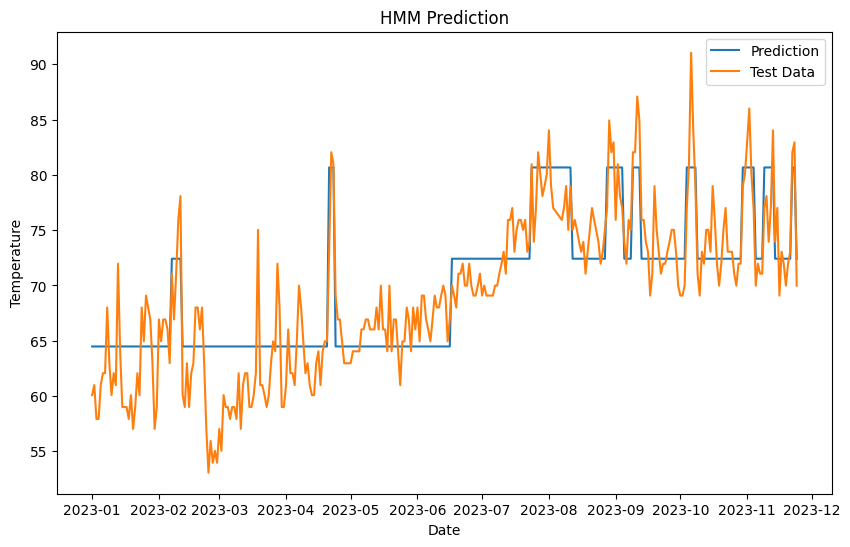

In [103]:
#112.3 plot the hidden states
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_test.index, pred_val, label='Prediction')
ax.plot(df_test.index, df_test['air_temp_high_24_hour'].values.reshape(-1,1), label='Test Data')
ax.set_title('HMM Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend()
fig.show()




In [104]:
pred = model.predict(df)
state = np.array(pred)
    
#12.3 extract the states and the temperature
d = {"state": state, "Anom": df["air_temp_high_24_hour"]}
hmm_df = pd.DataFrame(data=d)  
print(hmm_df)
statelist = []
datelist = []
for i in range(components):
    state = hmm_df[hmm_df['state'] == i]["Anom"]
    statelist.append(state)
    date = hmm_df[hmm_df['state'] == i].index
    datelist.append(date)



            state   Anom
Date                    
2023-11-24      1  69.98
2023-11-23      0  82.94
2023-11-22      0  82.04
2023-11-21      2  73.04
2023-11-20      2  71.96
...           ...    ...
2005-01-05      1  53.96
2005-01-04      1  57.02
2005-01-03      1  55.94
2005-01-02      1  57.02
2005-01-01      1  57.92

[6865 rows x 2 columns]


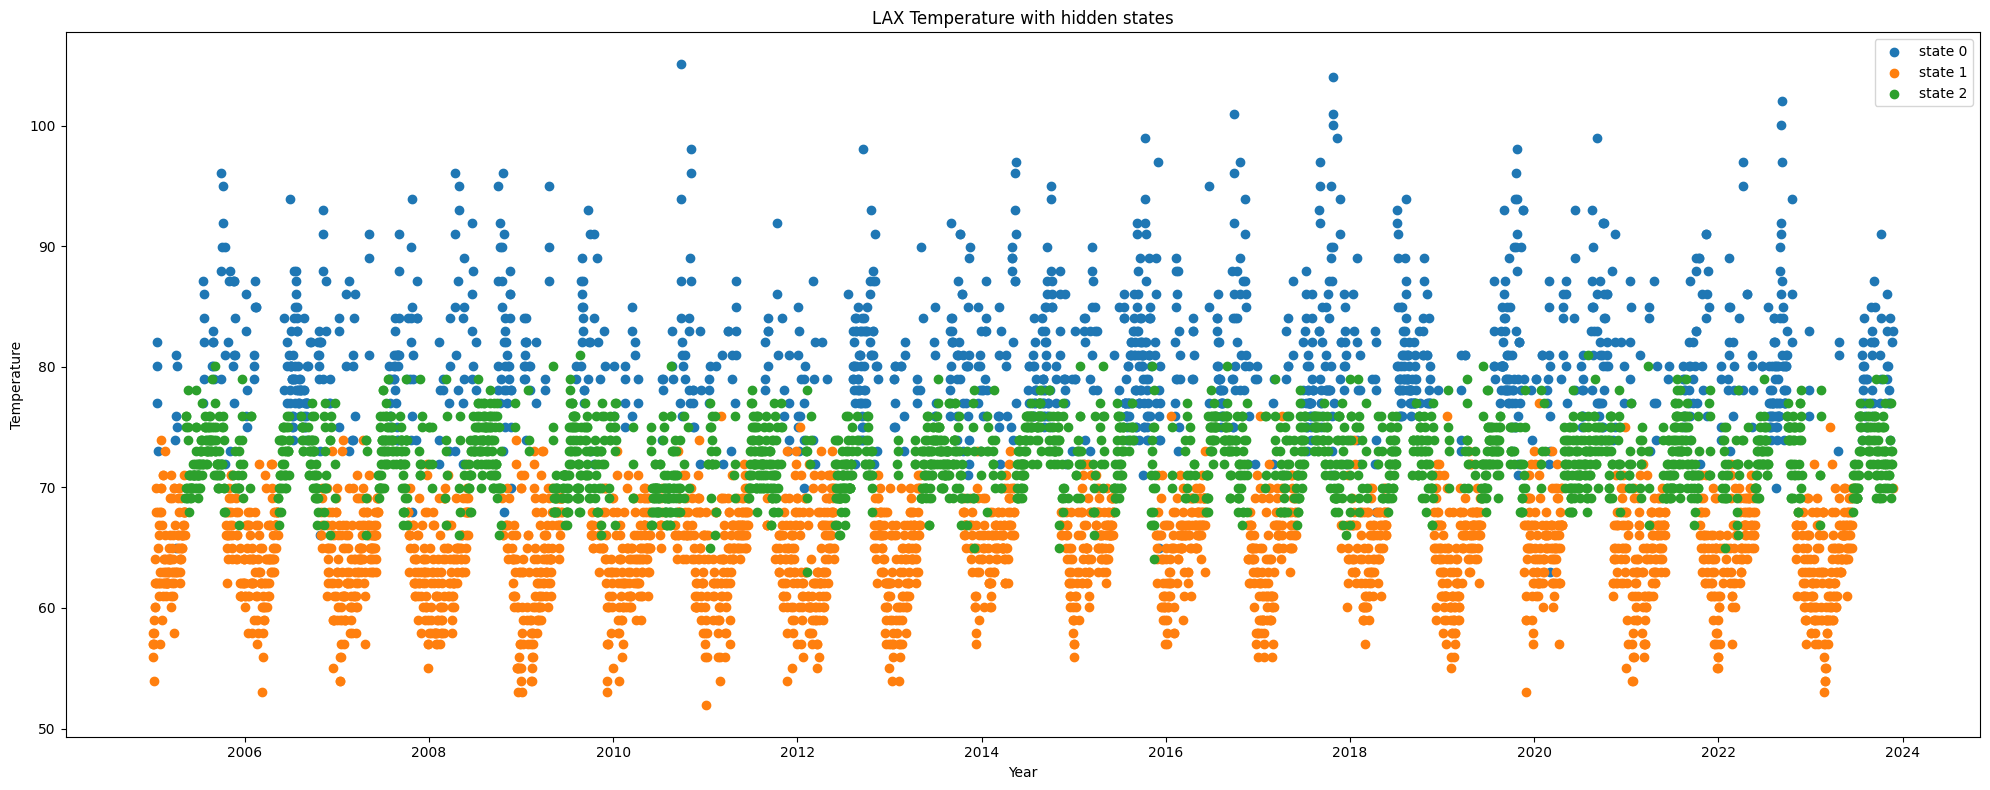

In [105]:
#13 plot the data
fig, ax = plt.subplots(figsize=(20, 8))
for i in range(components):
    ax.scatter(datelist[i], statelist[i], label=f'state {i}')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('LAX Temperature with hidden states')
ax.legend()
fig.tight_layout()
fig.savefig('hmm')
    